<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/04_insurance_wrapup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Insurance - a Federated Learning Use Case.

Revision by Destatis (Julius Weißmann and Oliver Hauke)

## Summary
---

- We stablized the centralized deep neural network (DNN)
  - model with more units and layers, without dropout, Xavier Initializion
  - more robust, faster and precise results
- We fixed the Federated Learning (FL) Algorithm
  - same model as in the centralized setting
  - great improvement in loss, MAE similiar to centralized setting
- outline
  - FL highly suitable for the available data
  - suggestions:
    - fixed train/val/test-split for centralized vs federated
    - cross validation
    - tests for 5 or 9 features

## Initial Results
---

### Centralized

*Training Performance after tuning:*
![](https://github.com/Olhaau/fl-official-statistics-addon/blob/main/original_work/med-insurance/rsquared_hyperparams.jpg?raw=1)




### Federated

S. 
https://github.com/joshua-stock/fl-official-statistics/blob/main/med-insurance/med-insurance-federated.ipynb

- "*Ergebnisse sehen deutlich schlechter aus als zentralisiert.*"
- "*MAE geht nicht unter ~8700 (vs. ~2900 im zentralisierten Modell)*"
- "*R² ist negativ!*"

## Setup
---

In [1]:
# Is a repo-clone and installs needed (e.g. in colabs)? 
need_clone_install = True

### Pull Repo

In [22]:
if need_clone_install:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

Cloning into 'fl-official-statistics-addon'...
remote: Enumerating objects: 865, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 865 (delta 30), reused 15 (delta 10), pack-reused 818
Receiving objects: 100% (865/865), 33.12 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (390/390), done.
/content/fl-official-statistics-addon
Already up to date.


### Installs

#### Python Version

In [16]:
#https://www.datasciencelearner.com/change-python-version-in-google-colab-steps/
if True:
  !python --version
  print("-----------------------------------------------------------")
  !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
  !sudo update-alternatives --config python3
  print("-----------------------------------------------------------")
  !python --version

Python 3.8.10
There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
  0            /usr/bin/python3.8   1         auto mode
* 1            /usr/bin/python3.8   1         manual mode
  2            /usr/bin/python3.9   1         manual mode

Press <enter> to keep the current choice[*], or type selection number: 2
update-alternatives: using /usr/bin/python3.9 to provide /usr/bin/python3 (python3) in manual mode
Python 3.9.16


#### Packages

In [17]:
if need_clone_install:
  #!pip install --quiet nest-asyncio==1.5.6
  #!pip install --quiet tensorflow==2.11.*
  !pip install --quiet tensorflow-federated==0.48.*
  !pip install --quiet tensorflow-addons==0.19.*

In [18]:
!pip list

Package                       Version
----------------------------- ------------
absl-py                       1.0.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         21.4.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    3.1.1
catalogue                     2.0.8
certifi     

### Imports

In [53]:
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score

# DNN
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, ReLU
from tensorflow_addons.metrics import RSquare

# TFF
import tensorflow_federated as tff

## Ingest Data
---

In [23]:
df = pd.read_csv("output/data/insurance-clean.csv", index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,0.0


### Train Test Split

In [26]:
# Divide data into train and test data
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region0', 'region1', 'region2', 'region3']
target = 'charges'

df_ml = df[features + [target]]

X_train, X_test, y_train, y_test = train_test_split(
    df_ml[features], df_ml[[target]], 
    test_size = 0.2, random_state = 42, shuffle = True)

## Support
---

In [ ]:
# diagnostics plot
def plot_loss(history, y_min=None, y_max=None, save_path=None, title = None):
    """Plot the training history and save the figure.

    :param history: The history object including the metrics to plot
    :type history: keras.callbacks.History
    :param y_min: The lover limit of the plot
    :type y_min: float, optional
    :param y_max: The upper limit of the plot
    :type y_max: float, optional
    :param save_path: The path to save the plot, if None, it will not be saved
    :type save_path: str, optional
    """
    plt.plot(history.history['r2_score'], label='train R^2')
    plt.plot(history.history['val_r2_score'], label='eval R^2')
    if y_min is not None and y_max is not None:
        plt.ylim([y_min, y_max])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path)

## Centralized Neural Networks
---

### Initial Model

#### Define + Compile

In [45]:
model0 = Sequential()
model0.add(Dense(32, input_dim = 9))
model0.add(ReLU())
model0.add(Dropout(0.05))
model0.add(Dense(16))
model0.add(ReLU())
model0.add(Dense(1))


model0.compile(
      loss = 'mean_squared_error', 
      optimizer = tf.optimizers.SGD(),
      metrics = ["mae", 'mean_squared_error', r2_score], 
      run_eagerly = True
      )

model0.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                320       
                                                                 
 re_lu_8 (ReLU)              (None, 32)                0         
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 re_lu_9 (ReLU)              (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                                 
Total params: 865
Trainable params: 865
Non-trainable 

#### Train

In [54]:
rtime = time.time() 
tf.random.set_seed(42)

with tf.device('/device:GPU:0'):
  hist0 = model0.fit(
      X_train, y_train,
      shuffle = True,
      validation_split = 0.2,
      epochs = 100,
      verbose = 0
  )

rtime = time.time() - rtime
print(rtime / 60)

KeyboardInterrupt: ignored

#### Evaluate

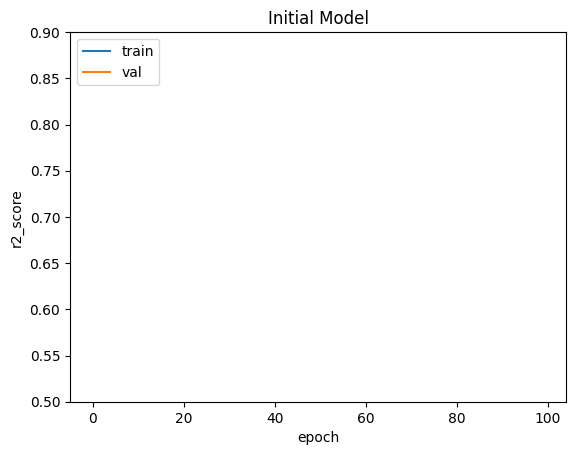

In [74]:
def plot_loss(hist, msr = 'loss'):
  plt.plot(hist.history[msr])
  plt.plot(hist.history['val_' + msr])
  plt.ylabel(msr)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')


plot_loss(hist0, 'r2_score')
plt.title('Initial Model')
plt.ylim([0.5, 0.9])
plt.show()
#fig = plt.figure()
#fig.savefig(plot_experiment_path + "/40_40_20_mse_adam_0_05_ReLU_bs256.png", dpi=fig.dpi)

In [68]:
# Test
pd.DataFrame({
    'measure': ["mae", 'mse', 'r2_score'],
    'value': hist0.model.evaluate(X_test, y_test, verbose = 0)[1:]
})

,measure,value
0,mae,9.683215e+03
1,mse,1.556015e+08
2,r2_score,-3.070631e-02


### Improved Model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 40)                400       
                                                                 
 re_lu_13 (ReLU)             (None, 40)                0         
                                                                 
 dense_24 (Dense)            (None, 40)                1640      
                                                                 
 re_lu_14 (ReLU)             (None, 40)                0         
                                                                 
 dense_25 (Dense)            (None, 20)                820       
                                                                 
 re_lu_15 (ReLU)             (None, 20)                0         
                                                                 
 dense_26 (Dense)            (None, 1)               

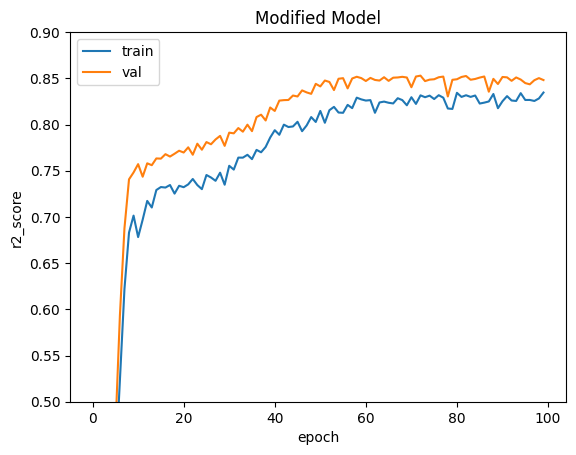

-- Test Performance --


,measure,value
0,mae,2.689693e+03
1,mse,2.016260e+07
2,r2_score,8.543426e-01


In [75]:
# define + compile
model = Sequential()
model.add(Dense(40, input_dim = 9))
model.add(ReLU())
model.add(Dense(40))
model.add(ReLU())
model.add(Dense(20))
model.add(ReLU())
model.add(Dense(1))
# removed dropout, more units and another big layer in the middle

model.compile(
      loss = 'mean_squared_error', 
      optimizer = tf.optimizers.Adam(learning_rate = .05),
      # Adam + lower learning rate
      metrics = ["mae", 'mean_squared_error', r2_score], 
      run_eagerly = True
      )

model.summary()
print("=================================================================")

# train
rtime = time.time() 
tf.random.set_seed(42)

with tf.device('/device:GPU:0'):
  hist = model.fit(
      X_train, y_train,
      batch_size = 128, # <- higher batch_size
      shuffle = True,
      validation_split = 0.2,
      epochs = 100,
      verbose = 0
  )

rtime = time.time() - rtime
print('-- Training --')
print('time to train: ', rtime / 60)
print("=================================================================")

# evaluate
plot_loss(hist, 'r2_score')
plt.title('Modified Model')
plt.ylim([0.5, 0.9])
plt.show()
#fig = plt.figure()
#fig.savefig(plot_experiment_path + "/40_40_20_mse_adam_0_05_ReLU_bs256.png", dpi=fig.dpi)

# Test
print("=================================================================")
print("-- Test Performance --")
pd.DataFrame({
    'measure': ["mae", 'mse', 'r2_score'],
    'value': hist.model.evaluate(X_test, y_test, verbose = 0)[1:]
})

## Federated Learning
---

### Setup

### FedAvg